In [1]:
import numpy as np
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pickle
from copy import deepcopy as copy
import pyTorchTemplate as ptt
# from torchsummary import summary
from pImpactR import opt

In [2]:
nSample_each_iter = 256
nSample_0th_iter = 2048

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# path = '/content/drive/My Drive/WorkSpace/ML/SurrogateModel/'
path = os.getcwd()

# Preprocess Data

## preview 

In [4]:
ap1_x,ap1_y = 4e-3, 5.5e-3
ang = np.arange(0.0,2*np.pi,2*np.pi/1024)
c = np.cos(ang)
s = np.sin(ang)

In [5]:
nx = 50
testP = 0.0
sig = 0.015
k=0
pTest = []
for x in np.linspace(-ap1_x*0.95,ap1_x*0.95,nx):
    for y in np.linspace(-ap1_y*0.95,ap1_y*0.95,nx):
        circ = np.sqrt((x/ap1_x)**2 + (y/ap1_y)**2)
        arcR = np.sqrt(((x-1.3*ap1_x)/ap1_x)**2 + (y/(1.1*ap1_y))**2)
        arcL = np.sqrt(((x+1.3*ap1_x)/ap1_x)**2 + (y/(1.1*ap1_y))**2)
        if circ < 0.95 and y>0:
            if x> 0 and 0.6 < arcR and (circ > 0.75 or  arcR < 0.8):
                pTest.append([x,y])
                k=k+1
            elif x<0 and 0.6 < arcL and (circ > 0.75 or  arcL < 0.8):
                pTest.append([x,y])
                k=k+1
pTest0 = np.array(pTest)
pTest1 = copy(pTest0)
pTest2 = copy(pTest0)
pTest = np.concatenate((pTest0,pTest1,pTest2))
npt = len(pTest0)
npt

352

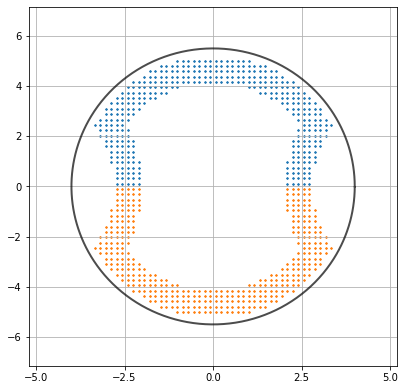

In [6]:
fig = plt.figure(figsize=[3.3*2,3.3*2])
plt.scatter(pTest[:,0]*1e3, pTest[:,1]*1e3,s=1)
plt.scatter(pTest[:,0]*1e3,-pTest[:,1]*1e3,s=1)
plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
plt.xticks([-5,-2.5,0,2.5,5])
plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)
plt.grid()

In [7]:
data = pickle.load(open(path+'/data_4_surrogate.pickle','rb'))
data.keys()

dict_keys(['regular', 'chaotic'])

In [8]:
data['regular'].keys()

dict_keys(['inputs', 'outputs'])

In [9]:
data['regular']['inputs'][:2]

[array([-0.93794949, -0.08133844,  1.59811762,  1.13538875, -1.72561006,
        -1.50714148, -0.82422489, -0.62967339, -2.44222827, -2.21708325,
        -1.84016845,  0.76794548]),
 array([ 0.72850738,  1.88325074,  0.12283435,  0.81260331, -0.96071658,
        -2.70046438,  2.59700925,  0.31247915,  0.13730186, -2.63868598,
        -2.16306279,  2.48377642])]

In [10]:
data['regular']['outputs'][:2]

[[array([  0,   7,   8,  11,  12,  13,  16,  17,  18,  19,  20,  21,  22,
          23,  24,  29,  30,  31,  32,  33,  36,  37,  38,  39,  40,  41,
          44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
          57,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
          72,  73,  74,  75,  78,  79,  80,  81,  82,  83,  84,  85,  86,
          87,  88,  89,  92,  93,  94,  95,  96,  97,  98,  99, 100, 103,
         105, 108, 109, 110, 113, 114, 115, 116, 118, 119, 120, 122, 124,
         125, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141,
         142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 156,
         157, 159, 161, 162, 163, 164, 167, 168, 169, 170, 171, 172, 173,
         174, 175, 176, 178, 179, 180, 181, 183, 185, 186, 188, 189, 191,
         194, 196, 197, 198, 201, 202, 206, 207, 208, 212, 213, 214, 215,
         217, 218, 220, 223, 224, 229, 230, 231, 232, 236, 237, 238, 241,
         243, 244, 250, 251, 252, 253,

## Re-struct data into model input and output

#### regular 

In [11]:
data_list = []

for i in range(len(data['regular']['outputs'])):
    inputs = data['regular']['inputs'][i].astype(np.float32)
    if np.all(inputs == np.zeros(12)):
        print(inputs)
        continue
    outputs = data['regular']['outputs'][i]
    indx = outputs[:3]
    diff = outputs[3:]
    nptNaN = [np.sum(np.isnan(diff[i])) for i in range(3)]
    if np.sum(nptNaN) > 0:
        print(i)
    diffSum0 = np.array([np.nansum(diff[i]) for i in range(3)])
    diffSum1 = diffSum0+ np.array([np.nanmax(diff[i])*(npt-len(indx[i])+nptNaN[i]) for i in range(3)])
    diffMean = [diffSum1[i]/npt for i in range(3)]
    obj = np.log10(0.15*diffMean[0] +0.7*diffMean[1] +0.15*diffMean[2])
    data_list.append([inputs, np.array([obj])])
    
data_list = np.array(data_list)    

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
regular_outputs = np.concatenate(data_list[:, 1],axis=0)

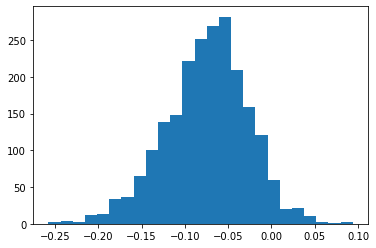

In [13]:
plt.hist(regular_outputs,bins=25);

#### chaotic

In [14]:
min_ragular_obj = np.min(regular_outputs)
max_ragular_obj = np.max(regular_outputs)
ave_ragular_obj = np.mean(regular_outputs)
std_reguar_obj  = np.std(regular_outputs)

data_list = data_list.tolist()
for i in range(len(data['chaotic']['outputs'])):
    inputs = data['chaotic']['inputs'][i].astype(np.float32)
    nturn  = data['chaotic']['outputs'][i][0]
    nptLive= data['chaotic']['outputs'][i][1]
    obj = ave_ragular_obj + 2.0*std_reguar_obj  + (0.9*(1.0-nturn/100.0) + 0.1*(1.0 -nptLive/(3.0*npt*0.5)))*2.0*std_reguar_obj
    data_list.append([inputs, np.array([obj])])
    
data_list = np.array(data_list)    

In [15]:
min_ragular_obj, max_ragular_obj, std_reguar_obj

(-0.25753430901152413, 0.09389589164123935, 0.04793296137081666)

In [16]:
outputs = np.concatenate(data_list[:, 1],axis=0)

min_obj = np.min(outputs)
max_obj = np.max(outputs)
std_obj  = np.std(outputs)
min_obj, max_obj, std_obj

(-0.25753430901152413, 0.10726335466740622, 0.07780442037849952)

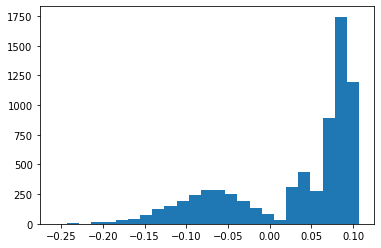

In [17]:
plt.hist(outputs,bins=25);

In [18]:
restructured_data = [copy(data_list)]

In [19]:
def restruct_data(data):
    data_list = []
    for i in range(len(data['regular']['outputs'])):
        inputs = data['regular']['inputs'][i].astype(np.float32)
        outputs = data['regular']['outputs'][i]
        indx = outputs[:3]
        diff = outputs[3:]
        nptNaN = [np.sum(np.isnan(diff[i])) for i in range(3)]
        diffSum0 = np.array([np.nansum(diff[i]) for i in range(3)])
        diffSum1 = diffSum0+ np.array([np.nanmax(diff[i])*(npt-len(indx[i])+nptNaN[i]) for i in range(3)])
        diffMean = [diffSum1[i]/npt for i in range(3)]
        obj = np.log10(0.15*diffMean[0] +0.7*diffMean[1] +0.15*diffMean[2])
        data_list.append([inputs, np.array([obj])])

    for i in range(len(data['chaotic']['outputs'])):
        inputs = data['chaotic']['inputs'][i].astype(np.float32)
        nturn  = data['chaotic']['outputs'][i][0]
        nptLive= data['chaotic']['outputs'][i][1]
        obj = ave_ragular_obj + 2.0*std_reguar_obj  + (0.9*(1.0-nturn/100.0) + 0.1*(1.0 -nptLive/(3.0*npt*0.5)))*2.0*std_reguar_obj
        data_list.append([inputs, np.array([obj])])
    
    return np.array(data_list)

### shuffle

In [20]:
argShuffle = np.arange(len(data_list[:, 1]))
np.random.shuffle(argShuffle)

In [21]:
data_list = data_list[argShuffle,:]

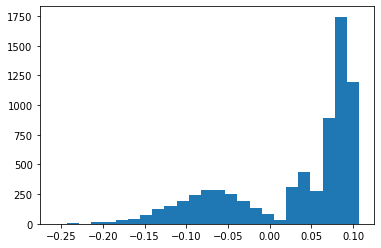

In [22]:
plt.hist(np.concatenate(data_list[:, 1],axis=0),bins=25);

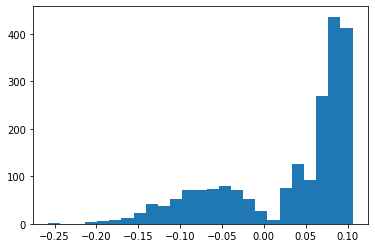

In [23]:
plt.hist(np.concatenate(data_list[:nSample_0th_iter, 1],axis=0),bins=25);

## Normalize Data

In [24]:
# # std of integrated sextupole strength of each multipolekick is 2.0
# data_list[:,0] = data_list[:,0]/2.0

# std_normalization = [np.std(data_list[:,1])]
# mean_normalization = [np.mean(data_list[:,1])]

# # normalize output 
# data_list[:,1] = (data_list[:,1]-mean_normalization[-1])/std_normalization[-1]

# print(std_normalization[-1],mean_normalization[-1])

In [25]:
def normalize_data(data_list_in,std=None,mean=None):
# std of integrated sextupole strength of each multipolekick is 2.0
    data_list = copy(data_list_in)
    data_list[:,0] = data_list[:,0]/2.0

    if std==None:
        std_normalization = np.std(data_list[:,1])
        mean_normalization = np.mean(data_list[:,1])
    else:
        std_normalization = std
        mean_normalization = mean        

    # normalize output 
    data_list[:,1] = (data_list[:,1]-mean_normalization)/std_normalization

    print('std_normalization,mean_normalization',std_normalization,mean_normalization)
    
    return data_list, std_normalization, mean_normalization

In [26]:
def unnormalize_data(outputs,std,mean):
# std of integrated sextupole strength of each multipolekick is 2.0
    return std*outputs+mean

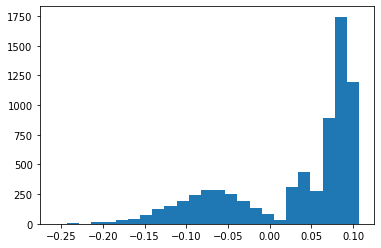

In [27]:
plt.hist(np.concatenate(data_list[:, 1],axis=0),bins=25);

In [28]:
data_list, std, mean = normalize_data(data_list)
normalization_std = [copy(std)]
normalization_mean = [copy(mean)]

std_normalization,mean_normalization [0.07780442] [0.03014876]


In [29]:
# plt.hist(np.concatenate(data_list[:, 1],axis=0),bins=25);

In [30]:
data_list = data_list.tolist()
for input,output in data_list:
    input = input.tolist()

## Build data loader

In [31]:
# data_list = data_list.tolist()
train_data_loader = torch.utils.data.DataLoader(data_list[:nSample_0th_iter]                    , batch_size=128, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(data_list[nSample_0th_iter:2*nSample_0th_iter]  , batch_size=128, shuffle=True)
val_data_loader   = torch.utils.data.DataLoader(data_list[2*nSample_0th_iter:3*nSample_0th_iter], batch_size=128, shuffle=True)

In [32]:
# for inputs, outputs in train_data_loader:
#     plt.hist(outputs[:,0],bins=20,range=(-4.0,1.5));

# 0th iter

## Surrogate Model

#### train

In [33]:
model = ptt.FCNN(nodes=[12,128,16,1],
                 activation=torch.nn.ReLU(inplace=True), 
                 dropout_p=0.1)

In [34]:
ptt.count_parameters(model)

3745

In [35]:
model, history = ptt.train_supervised(model,1.0e-3,200,'surrogate_iter_0th',
                                   train_data_loader,test_data_loader,#val_data_loader,
                                   criterion=torch.nn.MSELoss(),
                                   disp = False, get_best_model = True
                                   )

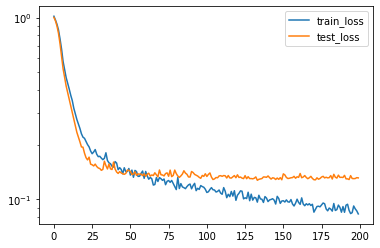

In [36]:
ptt.plot.history(history)

In [37]:
ptt.get_val_loss_supervised(model,val_data_loader,criterion=torch.nn.MSELoss())

0.12930559555524138

#### optimize over surrogate model

In [38]:
def obj(x):
    inputs = torch.from_numpy(x).float().to(ptt.device)
    model.eval()
    with torch.no_grad():
        model_output = model(inputs)
    return model_output.item()

In [39]:
bounds = [(-3,3) for i in range(12)]

result = opt.differential_evolution(obj,bounds,popsize=nSample_each_iter,
                                    disp=True,workers=4,maxiter=1000,
                                    strategy="rand1bin",tol=0.02)

result.population_energies = unnormalize_data(result.population_energies,
                                              normalization_std[-1],
                                              normalization_mean[-1])
pickle.dump(result,open('optim_result_surrogate_0th_iter.pickle','wb'))

/home/kilean/WorkSpace/pImpactR/pImpactR/opt.py:518: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -0.28574
differential_evolution step 2: f(x)= -1.25376
differential_evolution step 3: f(x)= -1.73769
differential_evolution step 4: f(x)= -1.73769
differential_evolution step 5: f(x)= -1.73769
differential_evolution step 6: f(x)= -1.73769
differential_evolution step 7: f(x)= -2.22713
differential_evolution step 8: f(x)= -2.22713
differential_evolution step 9: f(x)= -2.22713
differential_evolution step 10: f(x)= -2.22713
differential_evolution step 11: f(x)= -2.22713
differential_evolution step 12: f(x)= -2.22713
differential_evolution step 13: f(x)= -2.32095
differential_evolution step 14: f(x)= -2.32095
differential_evolution step 15: f(x)= -2.4027
differential_evolution step 16: f(x)= -2.4027
differential_evolution step 17: f(x)= -2.53885
differential_evolution step 18: f(x)= -2.87872
differential_evolution step 19: f(x)= -2.87872
differential_evolution step 20: f(x)= -2.87872
differential_evolution step 21: f(x)= -2.87872
differential_evolution s

differential_evolution step 182: f(x)= -3.57311
differential_evolution step 183: f(x)= -3.57311
differential_evolution step 184: f(x)= -3.57311
differential_evolution step 185: f(x)= -3.57311
differential_evolution step 186: f(x)= -3.57311
differential_evolution step 187: f(x)= -3.57311
differential_evolution step 188: f(x)= -3.57311
differential_evolution step 189: f(x)= -3.57311
differential_evolution step 190: f(x)= -3.57311
differential_evolution step 191: f(x)= -3.57311
differential_evolution step 192: f(x)= -3.57311
differential_evolution step 193: f(x)= -3.57311
differential_evolution step 194: f(x)= -3.57311
differential_evolution step 195: f(x)= -3.57311
differential_evolution step 196: f(x)= -3.57713
differential_evolution step 197: f(x)= -3.57713
differential_evolution step 198: f(x)= -3.60847
differential_evolution step 199: f(x)= -3.60847
differential_evolution step 200: f(x)= -3.60847
differential_evolution step 201: f(x)= -3.60847
differential_evolution step 202: f(x)= -

In [40]:
result = pickle.load(open('optim_result_surrogate_0th_iter.pickle','rb'))

In [41]:
result

                 fun: -3.721864938735962
             message: 'Optimization terminated successfully.'
                nfev: 70413
                 nit: 274
          population: array([[0.41887649, 0.70713464, 0.55767146, ..., 0.58135128, 0.51977191,
        0.48962577],
       [0.45929204, 0.64407873, 0.55128054, ..., 0.48227218, 0.5197225 ,
        0.4767844 ],
       [0.33689989, 0.84821728, 0.55382689, ..., 0.56514214, 0.42353595,
        0.40119647],
       ...,
       [0.42486972, 0.75230366, 0.55210016, ..., 0.60190528, 0.43964644,
        0.32800995],
       [0.44659745, 0.68584604, 0.50925735, ..., 0.51739747, 0.47486943,
        0.40732206],
       [0.4460002 , 0.6755369 , 0.49721186, ..., 0.51472895, 0.51052937,
        0.35941122]])
 population_energies: array([-0.25942878, -0.24721396, -0.25099965, -0.24084836, -0.2529352 ,
       -0.24449921, -0.25100464, -0.24049843, -0.24948488, -0.24519079,
       -0.23525447, -0.24237343, -0.24305602, -0.24399576, -0.25329038,
      

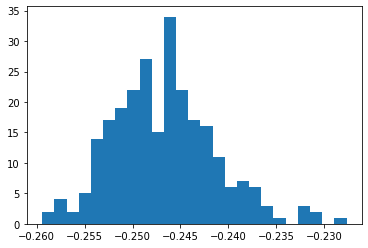

In [42]:
plt.hist(result.population_energies,bins=25);

#### get loss from realistic model 

In [43]:
sextStr = copy(result.population)
sextStr = sextStr*6.0 - 3.0
sextStr = sextStr*2.0

In [44]:
sextStr[:2]

array([[-0.97348208,  2.48561566,  0.69205752,  2.48451663, -4.80373989,
         4.74132738, -2.72162744, -0.66497009, -2.59534651,  0.97621541,
         0.23726297, -0.12449074],
       [-0.48849548,  1.72894476,  0.61536648,  1.65679687, -4.02792511,
         3.64809321, -2.55398234, -0.56315309, -1.29684277, -0.21273386,
         0.23667002, -0.27858719]])

In [45]:
result.population_energies[:2]

array([-0.25942878, -0.24721396])

In [46]:
import dataGenDA

reading ImpactZ input file (../test_iota_v8_4_SextOff_NLon.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [ ]:
data = dataGenDA.collect_data(sextStr)
pickle.dump(data,open('data_4_surrogate_1th_iter.pickle','wb'))

In [ ]:
data = pickle.load(open('data_4_surrogate_1th_iter.pickle','rb'))

In [ ]:
restructured_data.append(restruct_data(data))
data_list = copy(restructured_data[-1])

In [ ]:
plt.hist(np.concatenate(data_list[:, 1],axis=0),bins=25);

In [ ]:
restructured_data[1].shape

In [ ]:
restructured_data[-1] = np.concatenate(
    (restructured_data[-2][nSample_each_iter:nSample_0th_iter,:],
     restructured_data[-1]),
     axis=0)

In [ ]:
plt.hist(np.concatenate(restructured_data[-1][:, 1],axis=0),bins=25);

# 1st iter

In [ ]:
def get_next_verified_population_via_surrogateModelOptim(restructured_data_in,niter):
    data_list, std, mean = normalize_data(restructured_data_in)
    normalization_std.append(std)
    normalization_mean.append(mean)
    
    data_list = data_list.tolist()
    for input,output in data_list:
        input = input.tolist()
    train_data_loader = torch.utils.data.DataLoader(data_list, batch_size=128, shuffle=True)
    model = ptt.FCNN(nodes=[12,128,16,1],
                 activation=torch.nn.ReLU(inplace=True), 
                 dropout_p=0.1)
    model, history = ptt.train_supervised(model,1.0e-3,200,'surrogate_iter_'+str(niter)+'th',
                                   train_data_loader,#test_data_loader,#val_data_loader,
                                   criterion=torch.nn.MSELoss(),
                                   disp = True, get_best_model = True
                                   )
    plt.figure()
    ptt.plot.history(history)
    
    bounds = [(-3,3) for i in range(12)]
    result = opt.differential_evolution(obj,bounds,popsize=nSample_each_iter,disp=True,workers=4,maxiter=400,strategy="rand1bin")
    result.population_energies = unnormalize_data(result.population_energies,std,mean)
    pickle.dump(result,open('optim_result_surrogate_'+str(niter)+'th_iter.pickle','wb'))
#     result = pickle.load(open('optim_result_surrogate_'+str(niter)+'th_iter.pickle','rb'))
    
    plt.figure()
    plt.hist(result.population_energies,bins=25);
    plt.title('result.population_energies')
    
    sextStr = copy(result.population)
    sextStr = sextStr*6.0 - 3.0
    sextStr = sextStr*2.0
    data = dataGenDA.collect_data(sextStr)
    pickle.dump(data,open('data_4_surrogate_'+str(niter+1)+'th_iter.pickle','wb'))
#     data = pickle.load(open('data_4_surrogate_'+str(niter+1)+'th_iter.pickle','rb'))
        
    restructured_data.append(restruct_data(data))
    
    plt.figure()
    plt.hist(np.concatenate(restructured_data[-1][:, 1],axis=0),bins=25);
    plt.title('result.population_energies_verified')
    
    restructured_data[-1] = np.concatenate( (restructured_data[-2][nSample_each_iter:nSample_0th_iter,:],
                                             restructured_data[-1]),
                                             axis=0)

In [ ]:
get_next_verified_population_via_surrogateModelOptim(restructured_data[-1],1)